<a href="https://colab.research.google.com/github/msllc/GAN-Style-Transfer-HMW/blob/main/GAN_%26_Style_Transfer_HMW_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pillow==4.1.1
!pip3 install torch torchvision

In [2]:
%matplotlib inline
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name, imgsize):
    loader = transforms.Compose([
        transforms.Resize(imgsize),
        transforms.CenterCrop(imgsize),
        transforms.ToTensor()])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("images/Серов.jpg", 128)
style_img2 = image_loader("images/Кандинский.jpg", 128)
content_img = image_loader("images/Фото.jpg", 128)

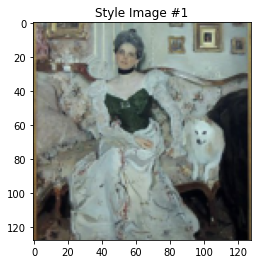

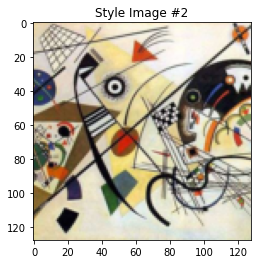

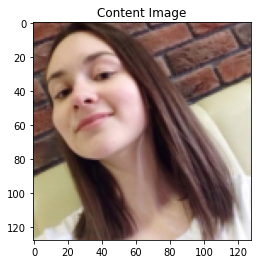

In [19]:
unloader = transforms.ToPILImage() 

plt.ion() 
def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

plt.figure()
imshow(style_img, title='Style Image #1')

plt.figure()
imshow(style_img2, title='Style Image #2')

plt.figure()
imshow(content_img, title='Content Image')

In [46]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

def gram_matrix(input):
        batch_size, h, w, f_map_num = input.size()
        features = input.reshape(batch_size * h, w * f_map_num)
        G = torch.mm(features, features.t())
        return G.div(batch_size * h * w * f_map_num)

class StyleLoss(nn.Module):
        def __init__(self, target1, target2):
            super(StyleLoss, self).__init__()
            self.target1 = gram_matrix(target1).detach()
            self.target2 = gram_matrix(target2).detach()
            self.loss = F.mse_loss(self.target1, self.target1)

        def forward(self, input):
            w = int((input.shape[3])/2)
            input_1, input_2 = input[:, :, :, :w], input[:, :, :, w:]
            G1, G2 = gram_matrix(input_1), gram_matrix(input_2)
            self.loss = F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2)
            return input

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std

In [47]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [48]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img_1, style_img_2, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target1, target2 = model(style_img_1).detach(), model(style_img_2).detach()
                style_loss = StyleLoss(target1, target2)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

def get_input_optimizer(input_img):
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [54]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img1, style_img2, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img1, style_img2, content_img)
        optimizer = get_input_optimizer(input_img)

        run = [0]
        while run[0] <= num_steps:

            def closure():
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 100 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img

In [57]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style_img2, input_img, 1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [100]:
Style Loss : 38.408390 Content Loss: 30.086967

run [200]:
Style Loss : 18.459105 Content Loss: 29.482241

run [300]:
Style Loss : 13.576203 Content Loss: 28.853550

run [400]:
Style Loss : 11.291452 Content Loss: 28.283842

run [500]:
Style Loss : 10.179554 Content Loss: 27.903929

run [600]:
Style Loss : 9.433143 Content Loss: 27.638744

run [700]:
Style Loss : 8.866455 Content Loss: 27.452509

run [800]:
Style Loss : 8.639428 Content Loss: 27.310314

run [900]:
Style Loss : 8.455402 Content Loss: 27.249641

run [1000]:
Style Loss : 8.203282 Content Loss: 27.167740



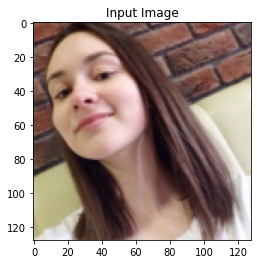

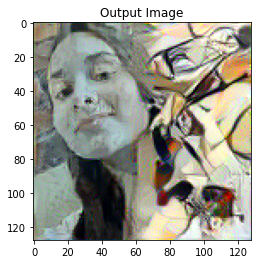

In [58]:
plt.figure()
imshow(content_img, title='Input Image')
imshow(output, title='Output Image')
plt.ioff()
plt.show()